# Dependencies

In [1]:
import matplotlib.pyplot as plt
import argparse
from itertools import chain
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import json
import matplotlib.pyplot as plt
from collections import Counter

2024-04-03 14:43:05.161247: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 14:43:09.111780: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data Loading

In [8]:
# Load the training data from the JSON file containing labeled data
inp_data = json.load(open("train.json"))

# Downsampling of negative examples to balance the dataset
p = []  # List to store positive samples (containing relevant labels)
n = []  # List to store negative samples (potentially misclassified entities)
for d in inp_data:
    if any(np.array(d["labels"]) != "O"):  # Check if any label is not "O" (indicating relevant label)
        p.append(d)
    else:
        n.append(d)
print("Original datapoints:", len(inp_data))

# Load external dataset for additional data points
external = json.load(open("external.json"))
print("External datapoints:", len(external))

# Load additional dataset for more data points
moredata = json.load(open("moredata.json"))
print("Moredata datapoints:", len(moredata))

# Combine the datasets: moredata, external, positive samples (p), and downsampled negative samples (n)
data = moredata + external + p + n[:len(n)//3]
print("Combined:", len(data))

Original datapoints: 6807
External datapoints: 4434
Moredata datapoints: 2000
Combined: 9333


# Counts of Relevant labels labels with no NER Samples

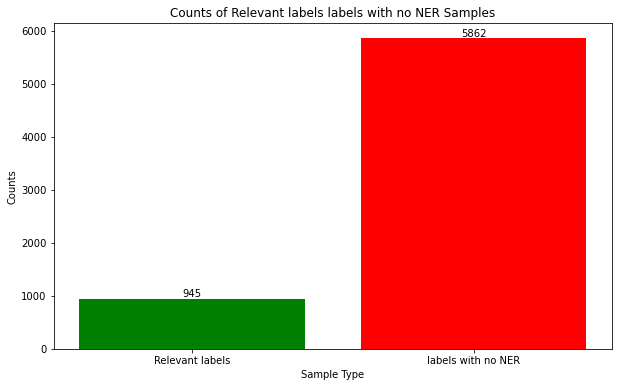

In [3]:
# Plotting
plt.figure(figsize=(10, 6))

# Counting positive and negative samples
positive_count = len(p)
negative_count = len(n)

# Plotting positive and negative counts
bars = plt.bar(['Relevant labels', 'labels with no NER'], [positive_count, negative_count], color=['green', 'red'])

# Add counts on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), int(bar.get_height()),
             ha='center', va='bottom')

plt.xlabel('Sample Type')
plt.ylabel('Counts')
plt.title('Counts of Relevant labels labels with no NER Samples')
plt.show()

# Counts of Different Datasets

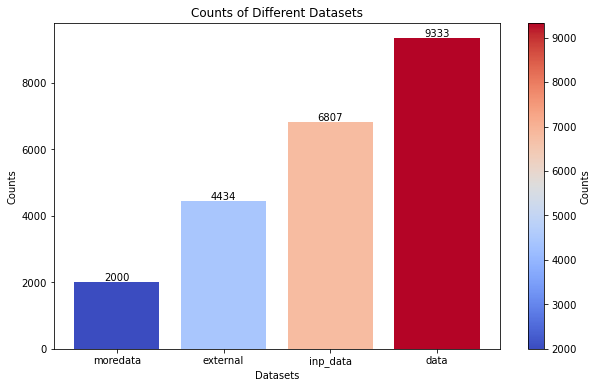

In [9]:
# Counting and sorting
categories = ['inp_data', 'external', 'moredata', 'data']
counts = [len(inp_data), len(external), len(moredata), len(data)]
sorted_indices = np.argsort(counts)
categories_sorted = [categories[i] for i in sorted_indices]
counts_sorted = [counts[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))

# Define colors based on counts
norm = Normalize(vmin=min(counts_sorted), vmax=max(counts_sorted))
colors = [plt.cm.coolwarm(norm(value)) for value in counts_sorted]

bars = plt.bar(categories_sorted, counts_sorted, color=colors)
plt.xlabel('Datasets')
plt.ylabel('Counts')
plt.title('Counts of Different Datasets')

# Add counts on top of each bar
for bar, count in zip(bars, counts_sorted):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count,
             ha='center', va='bottom')

# Add colorbar
sm = ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Counts')

plt.show()

# Distribution of Text Lengths

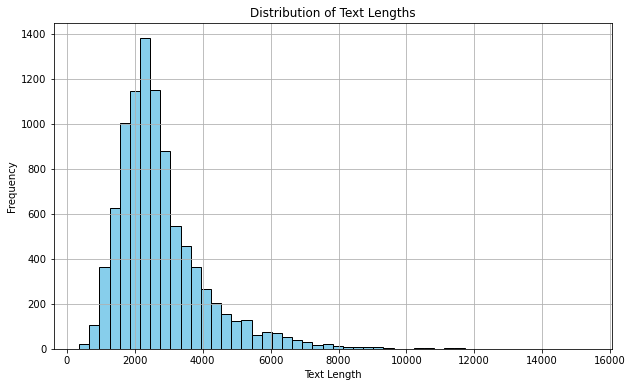

In [10]:
text_lengths = [len(d["full_text"]) for d in data]

plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.grid(True)
plt.show()

# Counts of Each Category Value(excluding O)

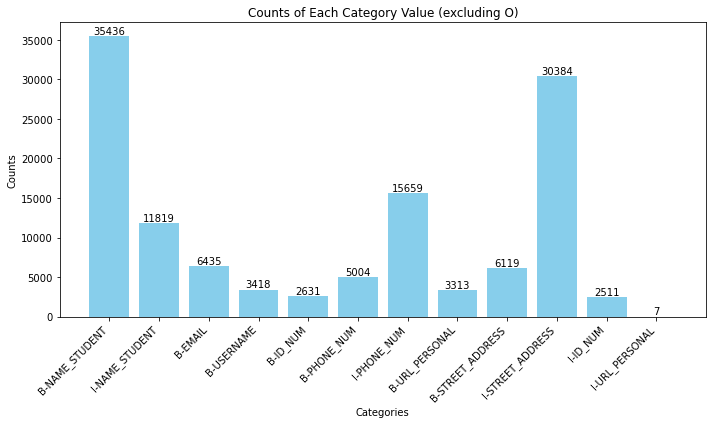

In [11]:
# Initialize a Counter to store the counts of category values
category_counts = Counter()

# Iterate through each JSON object in the list
for obj in data:
    # Get the "labels" list for the current document
    labels = obj["labels"]
    
    # Update the Counter with the counts of category values in the "labels" list
    category_counts.update(labels)

# Exclude a specific category
category_to_exclude = "O"
if category_to_exclude in category_counts:
    del category_counts[category_to_exclude]

# Extract categories and counts
categories = list(category_counts.keys())
counts = list(category_counts.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Counts of Each Category Value (excluding {})'.format(category_to_exclude))
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Add counts on top of each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [10]:
train_mapped = train_dataset.map(tokenize_train, fn_kwargs={"tokenizer": tokenizer, "label2id": label2id, "max_length": TRAINING_MAX_LENGTH}, num_proc=3)
test_mapped = test_dataset.map(tokenize_train, fn_kwargs={"tokenizer": tokenizer, "label2id": label2id, "max_length": TRAINING_MAX_LENGTH}, num_proc=3)

Map (num_proc=3):   0%|          | 0/9239 [00:00<?, ? examples/s]

Map (num_proc=3):   0%|          | 0/94 [00:00<?, ? examples/s]

In [ ]:
# Load the pre-trained token classification model with the specified parameters
model = AutoModelForTokenClassification.from_pretrained(
    TRAINING_MODEL_PATH,
    num_labels=len(all_labels),  # Number of labels for token classification
    id2label=id2label,  # Mapping from integer labels to their corresponding labels
    label2id=label2id,  # Mapping from labels to their corresponding integer identifiers
    ignore_mismatched_sizes=True  # Ignore mismatched sizes during training
)
model.to(device)

## Data Collation

In [24]:
# Initialize the data collator for token classification
collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)

## Compute Metrics Declartion

In [25]:
from seqeval.metrics import recall_score, precision_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score

def compute_metrics(p, all_labels):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [all_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [all_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Compute recall, precision, and f1-score
    recall = recall_score(true_labels, true_predictions)
    precision = precision_score(true_labels, true_predictions)
    f1 = f1_score(true_labels, true_predictions)

    # Calculate F1-score with beta = 5
    beta = 5
    f1_score_beta = (1 + beta**2) * recall * precision / (beta**2 * precision + recall)

    # Collect and return results
    results = {
        'recall': recall,
        'precision': precision,
        'f1': f1_score_beta
    }
    return results

## Training Arguments

In [ ]:
pip install tensorboard --quiet

In [26]:
# Define training arguments
args = TrainingArguments(
    output_dir=OUTPUT_DIR,  # Directory where model checkpoints and logs will be saved
    fp16=False,  # Whether to use 16-bit (mixed) precision training
    learning_rate=2e-5,  # Initial learning rate for training
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=1,
    #per_device_eval_batch_size=1,
    gradient_accumulation_steps=16,
    #per_device_train_batch_size=4,  # Batch size per GPU/CPU for training
    #gradient_accumulation_steps=2,  # Number of updates steps to accumulate before performing a backward/update pass
    report_to="tensorboard",  # Do not report training progress to any backend (e.g., Weights & Biases)
    evaluation_strategy="no",  # No evaluation during training
    do_eval=False,  # Do not perform evaluation during training
    save_total_limit=1,  # Maximum number of checkpoints to save
    logging_steps=20,  # Log training progress every specified number of steps
    lr_scheduler_type='cosine',  # Type of learning rate scheduler
    metric_for_best_model="f1",  # Metric used to determine the best model during training
    greater_is_better=True,  # Whether a higher value of the chosen metric indicates a better model
    warmup_ratio=0.1,  # Ratio of total training steps used for warmup
    weight_decay=0.01  # Strength of weight decay regularization
)

## Training the Model

- Once you are done with the training run this for reports and run it in an ssh where the output directory is specified in the folder
    - tensorboard --logdir=output_dir

In [27]:
# Initialize the Trainer object for training
trainer = Trainer(
    model=model,  # Pre-trained model to be trained
    args=args,  # Training arguments
    train_dataset=train_mapped,  # Training dataset
    data_collator=collator,  # Data collator for token classification
    tokenizer=tokenizer,  # Tokenizer object
    compute_metrics=partial(compute_metrics, all_labels=all_labels),  # Partial function for computing evaluation metrics
)
trainer.train()

/home/bommareddy.n/.local/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
20,2.762000
40,1.758200
60,0.479300
80,0.147600
100,0.083500
120,0.047600
140,0.028900
160,0.022300
180,0.018000
200,0.016700


TrainOutput(global_step=1572, training_loss=0.07430017114150084, metrics={'train_runtime': 1499.7663, 'train_samples_per_second': 16.801, 'train_steps_per_second': 1.048, 'total_flos': 6623083181113344.0, 'train_loss': 0.07430017114150084, 'epoch': 2.99})

In [36]:
from pathlib import Path
og_labels = test_mapped['labels']
predictions = trainer.predict(test_mapped).predictions
pred_softmax = np.exp(predictions) / np.sum(np.exp(predictions), axis = 2).reshape(predictions.shape[0],predictions.shape[1],1)
model_path='output/checkpoint-1500'
config = json.load(open(Path(model_path) / "config.json"))
id2label = config["id2label"]
preds = predictions.argmax(-1)
preds_without_O = pred_softmax[:,:,:12].argmax(-1)
O_preds = pred_softmax[:,:,12]

threshold = 0.9
preds_final = np.where(O_preds < threshold, preds_without_O , preds)

In [14]:
model_path = 'output/checkpoint-1500'
model = AutoModelForTokenClassification.from_pretrained(model_path)

In [15]:
# Extract relevant features from test_mapped
input_ids = torch.tensor(test_mapped["input_ids"])
token_type_ids = torch.tensor(test_mapped["token_type_ids"])
attention_mask = torch.tensor(test_mapped["attention_mask"])
og_labels = test_mapped['labels']

# Call the model with the extracted features
outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)

# Now you can access the logits from the outputs
predictions = outputs.logits

# Softmax normalization
pred_softmax = np.exp(predictions.detach().numpy()) / np.sum(np.exp(predictions.detach().numpy()), axis=2).reshape(predictions.shape[0], predictions.shape[1], 1)

# Extracting predictions without 'O' label
preds_without_O = pred_softmax[:, :, :12].argmax(-1)

# Extracting 'O' predictions
O_preds = pred_softmax[:, :, 12]

# Thresholding for 'O' predictions
threshold = 0.9
preds_final = np.where(O_preds < threshold, preds_without_O, predictions.argmax(-1))

In [16]:
df = pd.DataFrame({
    "og_label": og_labels,
    "pred_label": preds_final.tolist()
})

In [48]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Extraction labels excluding O's
og = df['og_label']
pred = df['pred_label']
o = []
p = []
for i in range(len(pred)):
    for j in range(len(pred[i])):
        if og[i][j] != 12:
            p.append(pred[i][j])
            o.append(og[i][j])
o_labels = [id2label[label_id] for label_id in o]
p_labels = [id2label[label_id] for label_id in p]
# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(o,p, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9969
Recall: 0.9965
F1 Score: 0.9967


/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
from sklearn.metrics import classification_report, precision_recall_fscore_support,confusion_matrix

# Assuming o contains your true labels, and p contains your predicted labels
labels = sorted(list(set(o)))  # Extract the unique labels present in your true labels

# Option 1: Classification Report
report = classification_report(o, p, labels=labels)
print(report)

# Option 2: Precision, Recall, F-score, and Support for each label
precision, recall, fscore, support = precision_recall_fscore_support(o, p, labels=labels)

# # If you want to see metrics for a specific label, e.g., label 1
# for i in range(0,11):
#     label_index = labels.index(i)  # Assuming '1' is a label and you want its index
#     print(f"Label {i} - Precision: {precision[label_index]}, Recall: {recall[label_index]}, F1-Score: {fscore[label_index]}")
#     print("_______________________________________________________________________________________________________________")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       514
           1       1.00      1.00      1.00       116
           2       1.00      1.00      1.00       380
           3       1.00      1.00      1.00       143
           4       1.00      0.99      0.99        89
           5       1.00      1.00      1.00       418
           6       1.00      0.93      0.96       115
           7       1.00      1.00      1.00        43
           8       1.00      1.00      1.00       142
           9       1.00      1.00      1.00       239
          10       1.00      1.00      1.00       380

   micro avg       1.00      1.00      1.00      2579
   macro avg       1.00      0.99      1.00      2579
weighted avg       1.00      1.00      1.00      2579



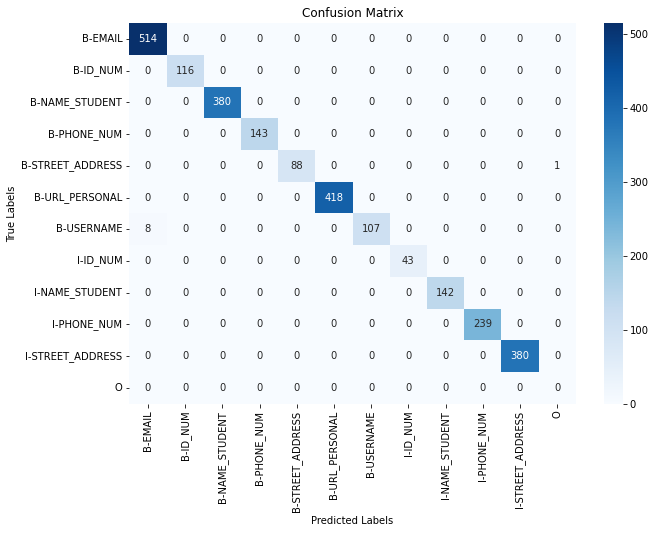

In [50]:
import seaborn as sns
# Assuming 'o' is your list of true labels and 'p' is your list of predicted labels
labels = sorted(list(set(o_labels + p_labels)))  # Get all unique labels from true and predicted labels combined

# Calculate confusion matrix
cm = confusion_matrix(o_labels, p_labels, labels=labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()